In [1]:
import pytest
import ipytest
import warnings
import numpy as np
import pandas as pd
import scipy.optimize as spo
import matplotlib.pyplot as plt
from test.model.port_schema import Portfolio
from util import data

ipytest.autoconfig()

%matplotlib inline

plt.style.use('ggplot2')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def price_data(syms, sd, ed):
    # get symbol price data for the dates between sd and ed both included
    dates = None
    if sd and ed:
        dates = pd.date_range(sd, ed)
    #
    # get prices by automatically adding SPY benchmark
    prices_all = data.get_data(syms, dates)
    #
    # forward fill should be done before backward fill
    prices_all.ffill(inplace=True)
    prices_all.bfill(inplace=True)
    #
    # only portfolio symbols
    prices = prices_all[syms]
    # only SPY, for comparison later
    prices_SPY = prices_all['SPY']
    #
    return prices, prices_SPY

In [3]:
def daily_port_vals(prices, wts, sv):
    # get normalized prices to bring all at 1 on the initial day
    normed = prices / prices.values[0]
    #
    # scale the allocation of syms assets as per their weightage in the portfolio
    alloced = normed.multiply(wts)
    #
    # get the daily individual asset values based on the starting investment in the portfolio
    pos_vals = alloced.multiply(sv)
    #
    # get the daily portfolio value
    port_vals = pos_vals.sum(axis=1)
    #
    return port_vals

In [4]:
def port_stats(portfolio, rfr, sf):
    # daily return
    dr = ( portfolio / portfolio.shift(1) ) - 1
    #
    # cumulative return
    cr = ( portfolio.iloc[-1] / portfolio.iloc[0] ) - 1
    #
    # average daily return
    adr = dr.mean()
    #
    # std of daily return
    sddr = dr.std()
    #
    # adjustment factor
    k = np.sqrt(sf)
    #
    # sharpe ratio <=> risk adjusted return
    sr = k * ( dr.subtract(rfr).mean() / sddr )
    #
    # end value of the portfolio
    ev = portfolio.iloc[-1]
    #
    return cr, adr, sddr, sr, ev

In [5]:
def gen_plot(portfolio, benchmark, subtitle=None):
    """Compare daily portfolio value with SPY using a normalized plot."""
    # normalized daily portfolio value
    portfolio = portfolio / portfolio.iloc[0]
    #
    # normalized daily SPY value (benchmark)
    benchmark = benchmark / benchmark.iloc[0]
    #
    # join dataframes along the columns for plotting
    df_temp = pd.concat([portfolio, benchmark], keys=['Portfolio', 'SPY'], axis=1)
    #
    # plot the data
    heading = 'Daily portfolio value and SPY'
    if subtitle:
        heading = heading + '\n' + subtitle
    data.plot_data(df_temp, title=heading)

In [6]:
def print_conf(portfolio, subtitle=None, weights=None):
    print(portfolio.description)
    if subtitle:
        print(subtitle)
    print('='*30)
    print(f'Symbols: {portfolio.symbols}')
    if weights:
        print(f'Updated weights: {weights}')
    else:
        print(f'Weights: {portfolio.weights}')
    print(f'Start date: {portfolio.start_date}')
    print(f'End date: {portfolio.end_date}')
    print(f'Initial value: {portfolio.initial_value}')
    print('-'*30)

In [7]:
def print_stats(cr, adr, sddr, sr, ev):
    print(f'Cumulative return: {cr:.3f}')
    print(f'Average daily return: {adr:.3f}')
    print(f'Standard deviation of daily return: {sddr:.3f}')
    print(f'Sharpe ratio: {sr:.3f}')
    print(f'Portfolio final value: {ev:.0f}')
    print()

In [8]:
def loss_func(wts, prcs, sv, rfr, sf):
    # get daily portfolio values based on adjusted weights
    port_vals = daily_port_vals(prcs, wts, sv)
    #
    # get portfolio statistics using new portfolio values
    # consider only the sharpe ratio for optimization
    _, _, _, sr, _ = port_stats(port_vals, rfr, sf)
    #
    # to maximize sharpe ratio we need to minimize its negative
    # so we consider negative sharpe ratio as the loss value
    return -sr

In [9]:
def optimize_weights(err_func, prcs, wts, sv, rfr, sf):
    # initial weights converted to numpy array for constraint calculations
    init_wts = np.array(wts, dtype=float)
    #
    # bounds
    # 0 < each of wts < 1
    limits = [(0, 1) for w in wts]
    #
    # constraints
    # sum(wts) = 1 => (sum(wts) - 1) = 0
    def add_to_one(x):
        return np.sum(x) - 1
    restrictions = {'type': 'eq', 'fun': add_to_one}
    #
    # minimization of loss function with bounds and constraints
    result = spo.minimize(
        err_func,
        init_wts,
        args=(prcs, sv, rfr, sf),
        method='SLSQP',
        bounds=limits,
        constraints=restrictions,
        options={'maxiter': 100, 'disp': False}
    )
    #
    # result with optimized weights stored in result.x
    return result

In [10]:
def optimize_portfolio(pf, rfr=0.0, sf=252.0, show=False):
    """
    Optimizes the given portfolio based on maximized sharpe ratio.

    Parameters:
    -----------
        pf: Portfolio object
        rfr: risk free rate
        sf: sampling frequency per year
        show: show plot or not
        
    Returns:
    --------
        None
    """
    # get price data for portfolio assets and benchmark
    assets, benchmark = price_data(pf.symbols, pf.start_date, pf.end_date)
    #
    # -------- Before Optimization --------
    #
    # get daily portfolio value based on actual weights
    port_vals_bf = daily_port_vals(assets, pf.weights, pf.initial_value)
    #
    # portfolio statistics based on actual weights
    cr, adr, sddr, sr, ev = port_stats(port_vals_bf, rfr, sf)
    #
    # show plot if needed
    st = '(Before Optimization)'
    if show:
        gen_plot(port_vals_bf, benchmark, subtitle=st)
    #
    # print the information
    print_conf(pf, subtitle=st)
    print_stats(cr, adr, sddr, sr, ev)
    #
    # -------- Optimization --------
    #
    # optimize weights based on loss minimization
    result = optimize_weights(
        loss_func, assets, pf.weights, pf.initial_value, rfr, sf
    )
    opti_wts = np.around(result.x, 2).tolist()
    #
    # -------- After Optimization --------
    #
    # get daily portfolio value based on optimized weights
    port_vals_af = daily_port_vals(assets, opti_wts, pf.initial_value)
    #
    # portfolio statistics based on optimized weights
    cr, adr, sddr, sr, ev = port_stats(port_vals_af, rfr, sf)
    #
    # show plot if needed
    st = '(After Optimization)'
    if show:
        gen_plot(port_vals_af, benchmark, subtitle=st)
    #
    # print the information
    print_conf(pf, subtitle=st, weights=opti_wts)
    print_stats(cr, adr, sddr, sr, ev)

In [11]:
@pytest.mark.parametrize(
    'port_test_conf',
    [
        'prj1_port_data_3.yaml',
    ],
    indirect=True
)
def test_portfolios(portfolio):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        optimize_portfolio(portfolio, show=True)

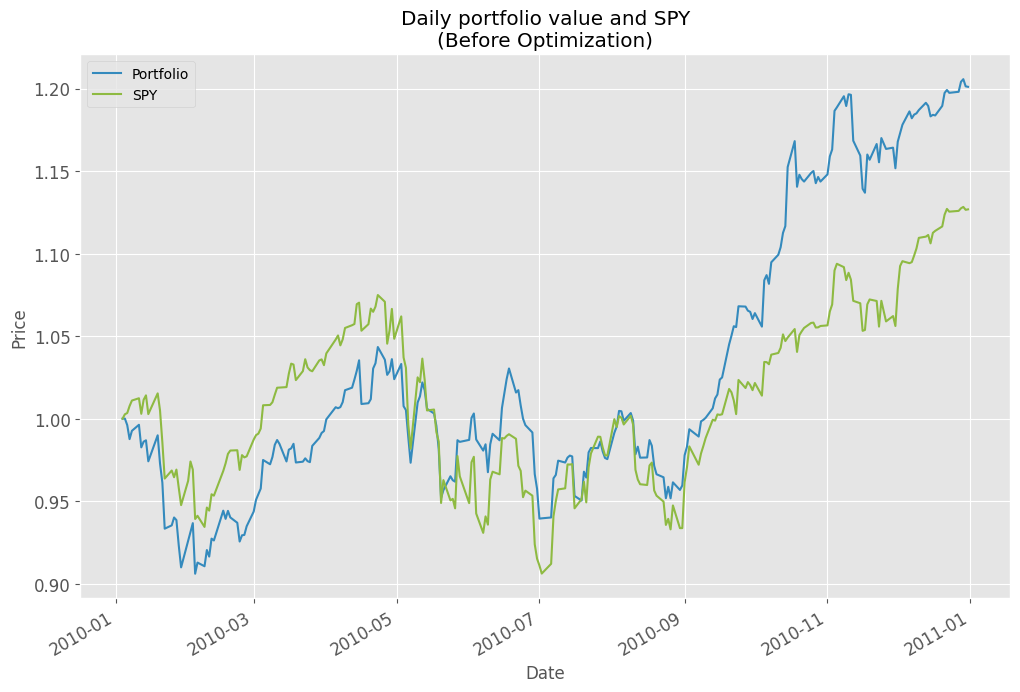

Test Portfolio 3
(Before Optimization)
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Weights: [0.25, 0.25, 0.25, 0.25]
Start date: 2010-01-01
End date: 2010-12-31
Initial value: 100000
------------------------------
Cumulative return: 0.201
Average daily return: 0.001
Standard deviation of daily return: 0.010
Sharpe ratio: 1.208
Portfolio final value: 120106



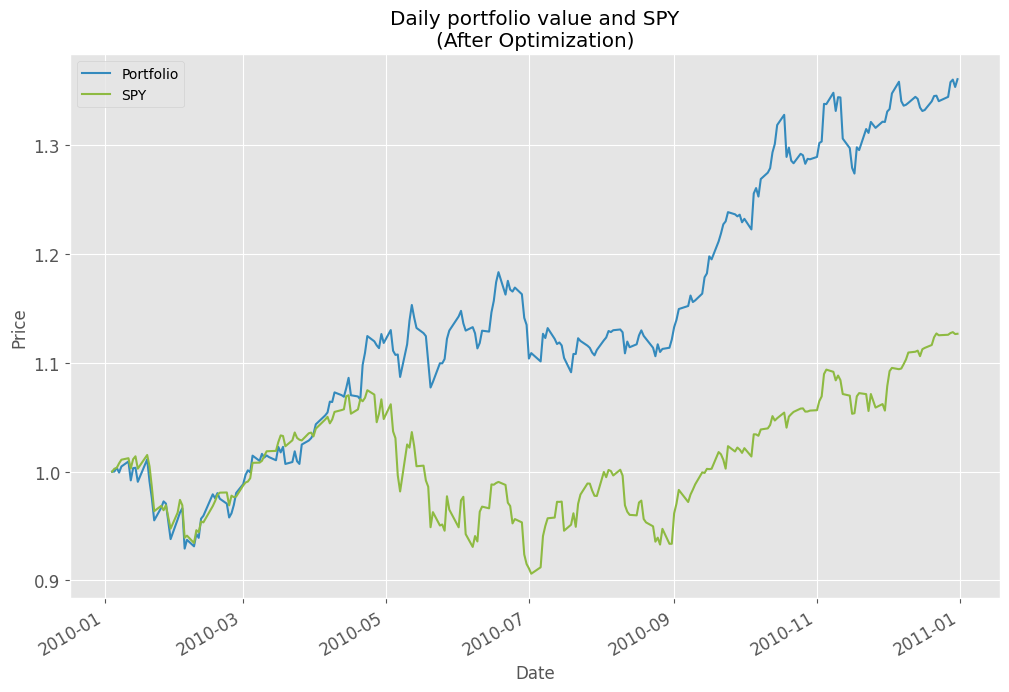

Test Portfolio 3
(After Optimization)
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Updated weights: [0.0, 0.4, 0.6, 0.0]
Start date: 2010-01-01
End date: 2010-12-31
Initial value: 100000
------------------------------
Cumulative return: 0.361
Average daily return: 0.001
Standard deviation of daily return: 0.010
Sharpe ratio: 2.004
Portfolio final value: 136090

.


<ExitCode.OK: 0>

In [12]:
ipytest.run('-qs', '--rootdir=../../')

---